In [4]:
#Importing the libraries
from qutip import *
from scipy import *
from pylab import *
import numpy as np
import math
import csv

#Problem parameters

#Units are: s-1, eV and Tesla hbar=1
pi=math.pi
muB = 5.788e-5  # Bohr Magneton in eV/Tesla
g=2 # g-factor for electron
gama=muB*g/2 # in eV/Tesla (why over 2?)
gama=gama*0.1519756e16 # in sec-1/Tesla (Converted using natural units, by taking hbar=1)
Bgeo=47e-6; #Geomagentic field in Tesla
Brf=150e-9 # Disturbing RF field of strength 150 nanoTesla
w = 2*gama*Bgeo # Frequency of externally applied RF field (corresponding to the Geomagnetic field Larmor frequency)
sqrt2=np.sqrt(2)
k=1e4#Yield decay rate
##############################################

# Define basis and tensor products 

#Spin up/down basis
up=basis(2,0)
down=basis(2,1)
#Two-electron spin basis
singlet=(tensor(up,down)-tensor(down,up))/sqrt2 # Singlet state with zero spin projection
trip0=(tensor(up,down)+tensor(down,up))/sqrt2 # Triplet state with zero spin projection
tripu= tensor(up,up) # Tirplet state with spin projection +1
tripd=tensor(down,down) # Triplet state with spin projection -1

#Defining nuclear spin X electronic spins vectors
#Using pad function to add two shelving states correspoding to the triplet and singlet yield
#unit() normalizes vectors
utu=Qobj(pad(tensor(up, tripu).unit(), ((0, 2), (0, 0)))) #Nuclear spin up & triplet with m=+1 
ut0=Qobj(pad(tensor(up, trip0).unit(), ((0, 2), (0, 0)))) #Nuclear spin up & triplet with m=0
utd=Qobj(pad(tensor(up, tripd).unit(), ((0, 2), (0, 0)))) #Nuclear spin up & triplet with m=-1
us=Qobj(pad(tensor(up, singlet).unit(), ((0, 2), (0, 0)))) #Nuclear spin up & singlet
dtu=Qobj(pad(tensor(down, tripu).unit(), ((0, 2), (0, 0)))) #Nuclear spin down & triplet with m=+1
dt0=Qobj(pad(tensor(down, trip0).unit(), ((0, 2), (0, 0)))) #Nuclear spin down & triplet with m=0
dtd=Qobj(pad(tensor(down, tripd).unit(), ((0, 2), (0, 0)))) #Nuclear spin down & triplet with m=-1
ds=Qobj(pad(tensor(down, singlet).unit(), ((0, 2), (0, 0)))) #Nuclear spin down & singlet
sy=basis(10,8) #Singlet yield
ty=basis(10,9) #Triplet yield

#Defining initial density matrix 
rho0=ket2dm(us)+ket2dm(ds) #density matrix for singlet with nuclear spin up and down
rho0=rho0/rho0.tr() #normalize density matrix


#Defining density matrices for triplet and singlet yields
SY=ket2dm(sy)
TY=ket2dm(ty)


##############################################

# Defining operators for Hamiltonian H

#Electron Zeeman operators
S1x=tensor(qeye(2),sigmax(),qeye(2)) # I x Sx x I
S2x=tensor(qeye(2),qeye(2),sigmax()) # I x I x Sx 
S1x_10=Qobj(pad(S1x.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sx operator for electron 1
S2x_10=Qobj(pad(S2x.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sx operator for electron 2
Sx=S1x_10+S2x_10 #Total Sx operator 
S1y=tensor(qeye(2),sigmay(),qeye(2)) # I x Sy x I
S2y=tensor(qeye(2),qeye(2),sigmay()) # I x I x Sy 
S1y_10=Qobj(pad(S1y.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sy operator for electron 1
S2y_10=Qobj(pad(S2y.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sy operator for electron 2
Sy=S1y_10+S2y_10 #Total Sy operator
S1z=tensor(qeye(2),sigmaz(),qeye(2)) # I x Sz x I 
S2z=tensor(qeye(2),qeye(2),sigmaz()) # I x I x Sz 
S1z_10=Qobj(pad(S1z.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sz operator for electron 1
S2z_10=Qobj(pad(S2z.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) #Sz operator for electron 2
Sz=S1z_10+S2z_10 #Total Sy operator

#Hyperfine operators
ISx8=tensor(sigmax(),qeye(2),sigmax()) # Sx x I x Sx
ISy8=tensor(sigmay(),qeye(2),sigmay()) # Sy x I x Sy
ISz8=tensor(sigmaz(),qeye(2),sigmaz()) # Sz x I x Sz
ISx=Qobj(pad(ISx8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
ISy=Qobj(pad(ISy8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
ISz=Qobj(pad(ISz8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
##############################################

#Hyperfine tensor in eV
#az=gama*Bgeo/4
az=1e-8*0.1519756e16
ax=az/2
ay=az/2
##############################################

#Defining Projection operators
P1=sy*us.dag()*sqrt(k)
P2=ty*ut0.dag()*sqrt(k)
P3=ty*utu.dag()*sqrt(k)
P4=ty*utd.dag()*sqrt(k)
P5=sy*ds.dag()*sqrt(k)
P6=ty*dt0.dag()*sqrt(k)
P7=ty*dtu.dag()*sqrt(k)
P8=ty*dtd.dag()*sqrt(k)

c_op_list = [P1,P2,P3,P4,P5,P6,P7,P8] #putting them together in a list
##############################################

tlist = linspace(0.0, float(6)/k, 20000) # Defining time instants for simulation
num=len(tlist)

#ME Solver options
opts = Odeoptions(nsteps=10000)


#Defining polar (0-2pi) and azimuthal (0-pi/2) angles for the geomagnetic field (they can be vectors too)
phi1=0;
theta= linspace(0.0, pi, 100);


# Defining time-dependent Hamiltonian Ht

#Time-dependent function, t is the time variable, 
#args can include any other parameter of the function: amplitude, frequency, width, etc..
def Bt(t, args):
    A = args['A'] #amplitude of oscilating field
    freq = args['freq'] #frequency of oscilating field
    return A*np.cos(t*freq)

#Defining arguments of the time-dependent function
args = {'A': Brf, 'freq': w}

#Defining polar (0-2pi) and azimuthal (0-pi/2) angles for the RF field (they can be vectors too)
phi2=0;
theta2=pi/2;

singlet_yield0=[]
singlet_yield=[]

timev=[]
#Running for-loop 
for th in range(len(theta)):
    print(th)
    #Zeeman Hamiltonian
    Bx=Bgeo*np.sin(theta[th])*np.cos(phi1)
    By=Bgeo*np.sin(theta[th])*np.sin(phi1)
    Bz=Bgeo*np.cos(theta[th])
    Hz=gama*(Sx*Bx+Sy*By+Sz*Bz)

    #Hyperfine Hamiltonian
    Hhf=(ax*ISx+ay*ISy+az*ISz)

    #Time-independent Hamiltonian
    H0=Hz+Hhf
    #print('theta = ', theta[th])
    
    #RF-field Zeeman Hamiltonian 
#     Bzrf=-np.sin(theta[th])*np.cos(phi2)
#     Byrf=np.sin(theta[th])*np.sin(phi2)
#     Bxrf=np.cos(theta[th])
#     Hrf=gama*(Sx*Bxrf+Sy*Byrf+Sz*Bzrf)
    th_rf = theta[th] + np.pi/2.
    
    Bxrf=np.sin(th_rf)
    Byrf=0.0
    Bzrf=np.cos(th_rf)
    
    Hrf=gama*(Sx*Bxrf+Sy*Byrf+Sz*Bzrf)
    
    args = {'A': Brf, 'freq': w}
    
    Hrft=[Hrf,Bt] #Time-dependent Hamiltonian H(t)
    
    H = [H0, Hrft]#Total Hamiltonian
     
    #QuTip Master Equation solver with Lindbland operator list
    tic = time.process_time()
    result = mesolve(H0, rho0, tlist, c_op_list, [SY], args = args);
    singlet_yield0.append(result.expect[0][num-1])

    result2 = mesolve(H, rho0, tlist, c_op_list, [SY], args = args);
    singlet_yield.append(result2.expect[0][num-1])
    toc = time.process_time()
    
    #print(toc-tic)
    
    timev.append(toc-tic)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


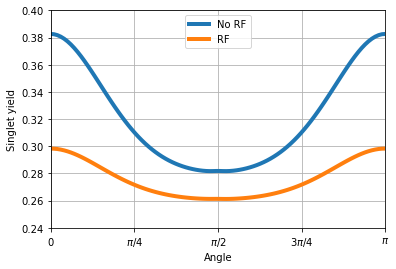

In [6]:
from importlib import reload 
#np.sum(timev)/60
len(singlet_yield0)
reload(plt)
plt.plot(theta,singlet_yield0,label='No RF',linewidth=4.0)
plt.plot(theta,singlet_yield,label='RF',linewidth=4.0)
plt.ylim((0.24,0.4))
plt.xlim((0.0,pi))
plt.xticks(ticks=np.arange(0, pi+0.01, np.pi/4), labels=['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']);
plt.xlabel('Angle')
plt.ylabel('Singlet yield');
plt.legend(loc='upper center');
plt.grid();
plt.savefig("out.pdf")

In [ ]:
#Zeeman Hamiltonian
theta1=pi/2
Bx=Bgeo*np.sin(theta1)*np.cos(phi1)
By=Bgeo*np.sin(theta1)*np.sin(phi1)
Bz=Bgeo*np.cos(theta1)
Hz=gama*(Sx*Bx+Sy*By+Sz*Bz)

#Hyperfine Hamiltonian
Hhf=(ax*ISx+ay*ISy+az*ISz)

#Time-independent Hamiltonian
H0=Hz+Hhf
#print('theta = ', theta[th])
    
#RF-field Zeeman Hamiltonian 
Bzrf=-np.sin(theta1+pi/2)*np.cos(phi2)
Byrf=np.sin(theta1+pi/2)*np.sin(phi2)
Bxrf=np.cos(theta1+pi/2)
Hrf=gama*(Sx*Bxrf+Sy*Byrf+Sz*Bzrf)

    
Hrft=[Hrf,Bt] #Time-dependent Hamiltonian H(t)
    
H = [H0, Hrft]#Total Hamiltonian
     
args = {'A': Brf, 'freq': w}
    
#QuTip Master Equation solver with Lindbland operator list


result2 = mesolve(H, rho0, tlist, c_op_list, [SY], args = args);
print(result2.expect[0][num-1])


#RF-field Zeeman Hamiltonian 
Bzrf=-np.sin(theta1-pi/2)*np.cos(phi2)
Byrf=np.sin(theta1-pi/2)*np.sin(phi2)
Bxrf=np.cos(theta1-pi/2)
Hrf=gama*(Sx*Bxrf+Sy*Byrf+Sz*Bzrf)

    
Hrft=[Hrf,Bt] #Time-dependent Hamiltonian H(t)
    
H = [H0, Hrft]#Total Hamiltonian
     
args = {'A': Brf, 'freq': w}
    
#QuTip Master Equation solver with Lindbland operator list


result2 = mesolve(H, rho0, tlist, c_op_list, [SY], args = args);
print(result2.expect[0][num-1])

In [ ]:
from importlib import reload 
#np.sum(timev)/60
len(singlet_yield0)
reload(plt)
plt.plot(theta,singlet_yield0,label='Singlet yield',linewidth=4.0)
plt.plot(theta,singlet_yield,label='Singlet yield',linewidth=4.0)
plt.ylim((0.24,0.4))